**Ціль:** Провести технічний аналіз акцій автомобільної компанії Ford Motor Company.


**Джерело даних:** https://www.alphavantage.co/

Проводимо ініціалізацю проекту, підключивши всі необхідні бібліотеки і задавши налаштування для зручного відображення.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_finance import candlestick2_ohlc, candlestick_ohlc
import matplotlib.dates as mdates
import time

In [2]:
%config InlineBackend.figure_format = 'svg'
# %config IPCompleter.greedy=True
pd.options.display.max_rows = 10
plt.rc('figure', figsize=(8, 5))

На сайті Alpha Vantage потрібно отримати спеціальний *api-ключ* за допомогою якого буде здійснюватись доступ до даних. Також потрібно знайти ярлик (symbol) компанії Ford.

In [3]:
api_key = 'PK4CSDV4WTP2HNPS'
ford_symbol = 'F'

Опишемо функцію для отримання даних з сайту Alpha Vantage.

In [4]:
def get_alpha_vantage(
        apikey, symbol,
        function='TIME_SERIES_DAILY',
        outputsize='compact',
        datatype='csv',
        **kwargs):
    base_url = 'https://www.alphavantage.co/query?'
    
    req = f'{base_url}function={function}&outputsize={outputsize}&datatype={datatype}&symbol={symbol}&apikey={apikey}'
    for key, val in kwargs.items():
        req += '&' + str(key) + '=' + val

    data = pd.read_csv(req, index_col='timestamp', parse_dates=True)    
    return data.sort_index()

Щоб отримати дані достатньо викликати данну функції з відповіднми параметрами.

In [5]:
ford_data = get_alpha_vantage(api_key, ford_symbol, outputsize='full')

In [6]:
ford_data

,open,high,low,close,volume
timestamp,,,,,
1998-01-02,48.69,48.87,48.12,48.25,3388033
1998-01-05,48.25,48.50,47.81,48.50,4463654
1998-01-06,48.25,48.25,47.00,47.69,4746085
1998-01-07,47.37,47.62,46.31,47.12,5791534
1998-01-08,46.31,46.62,44.94,45.06,6208020
...,...,...,...,...,...
2019-03-22,8.63,8.67,8.52,8.54,41963991
2019-03-25,8.56,8.65,8.47,8.51,45849484
2019-03-26,8.54,8.76,8.54,8.76,47852114


Ми успішно отримали дані про ціни компанії Ford в період з 1998 до сьогоднішнього дня. Для візуального аналізу побудуємо графік.

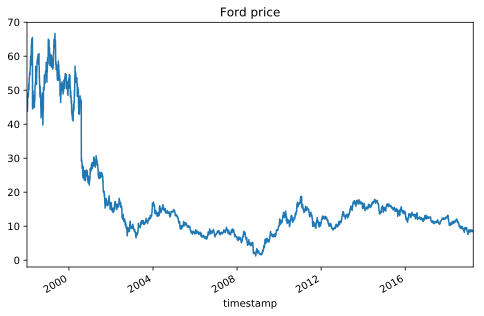

In [7]:
ford_data['close'].plot(title = 'Ford price')

На графіку видно, що ціни акцій Ford стабільно падають з 2014 року. Для аналізу візьмемо саме цей період.

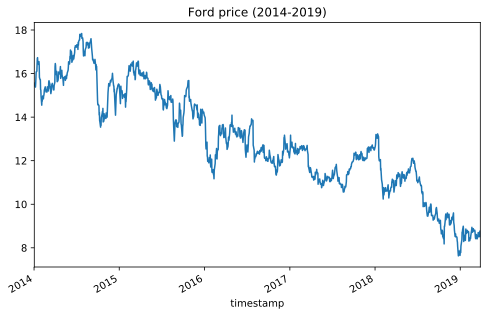

In [60]:
ford = ford_data.copy(deep=True)['2014':]
ford['close'].plot(title = 'Ford price (2014-2019)')

In [9]:
ford.describe()

,open,high,low,close,volume
count,1318.000000,1318.000000,1318.000000,1318.000000,1.318000e+03
mean,12.952485,13.063214,12.821060,12.941176,3.537705e+07
std,2.371240,2.378787,2.364666,2.372142,1.571594e+07
min,7.530000,7.850000,7.410000,7.630000,2.735950e+05
25%,11.282500,11.390000,11.185000,11.280000,2.501906e+07
50%,12.610000,12.700000,12.500000,12.600000,3.192860e+07
75%,15.010000,15.107500,14.830000,14.990000,4.205790e+07
max,18.010000,18.120000,17.780000,17.840000,1.421686e+08


З період 2014-2019 ціни на акції компанії Ford знаходились в межах 7.50-18 USD.


Опишемо функцію побудови японських свічок для наявних даних.

In [10]:
def plot_candlestick(data):
    format_data = data.copy()
    format_data['date']=format_data.index
    format_data = format_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    format_data['date']=format_data['date'].apply(mdates.date2num)
    ax = plt.axes()
    plt.xticks(rotation=80)
    interval = len(data)//10
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
   
    
    plt.ylabel('Price USD')
    plt.xlabel('Date')
    candlestick_ohlc(
        ax,
        quotes=format_data.values,
        width=0.5,
        colorup='g',
        colordown='r')

Застосуємо цю функцію для даних за 2019 рік

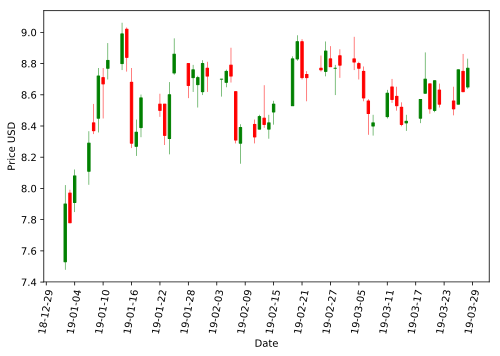

In [11]:
plot_candlestick(ford['2019':])

Також опишемо функцію яка обчислює лінії Боліджера та функцію для побудови графіку цих ліній.

In [13]:
def bollinger_bands(series, MA=20, k=2):
    sma =  series.rolling(window=MA).mean()
    rstd = series.rolling(window=MA).std()
    lower_band = sma - k * rstd
    upper_band = sma + k * rstd
    return lower_band, sma, upper_band

def plot_bollinger(series, color='#6666FF', symbol='', MA=20, k=2):

    lower_band, sma, upper_band = bollinger_bands(series, MA, k)

    ax = plt.axes()

    ax.set_title('{} Price and Bollinger Bands'.format(symbol))
    ax.set_xlabel('Date')
    ax.set_ylabel('SMA and Bollinger Bands')
    plt.xticks(rotation=80)
    interval = len(series)//10
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
   

    ax.plot(series.index, series, color=color, linewidth=1)

    ax.fill_between(
            series.index, lower_band, upper_band,
            color=color, alpha=0.1)
    ax.plot(
            series.index, lower_band, upper_band,
            color=color, linewidth=1, alpha=0.4)
    ax.plot(series.index, sma,
            color='red', linewidth=2, alpha=0.8)

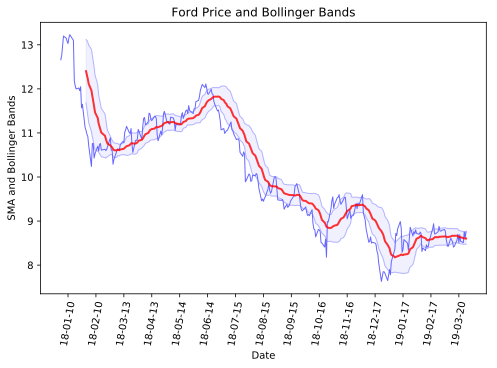

In [196]:
plot_bollinger(ford['2018':]['close'], symbol='Ford', MA=20, k=1)

Акції майже весь час знаходять всередині рукавів, для обчислення днів коли акції виходять за межі опишемо відповідну функцію

In [44]:
def check_bollinger(series, ma, k):
    lower_band, sma, upper_band = bollinger_bands(ford, MA=ma, k=k)

    indicator=pd.DataFrame(index=series.index)
    indicator['status']=0


    for index in ford.index: 
        if ford.loc[index]['close'] < lower_band.loc[index]['close']:
            indicator.loc[index]['status']=-1
        elif ford.loc[index]['close'] > upper_band.loc[index]['close']:
            indicator.loc[index]['status']=1

    day_to_buy = indicator[indicator['status'] < 0]
    day_to_sell = indicator[indicator['status'] > 0]
    
    return day_to_buy, day_to_sell

Таким чином ми можемо отримати дні в які ми маємо продавати і дні в які ми маєсо купувати.

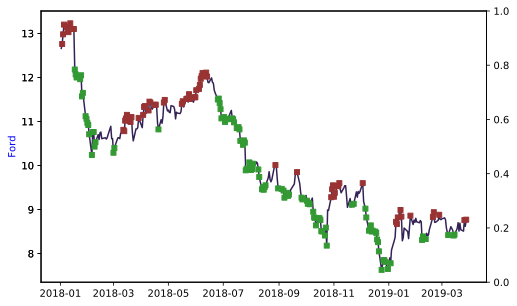

In [125]:
buy, sell = check_bollinger(ford, 20, 1)

fig, ax1 = plt.subplots()
ax1.plot(ford['2018':]['close'], color='#332255')
ax1.set_ylabel('Ford', color='b')
buy['price']=ford['close']
sell['price']=ford['close']
ax2 = ax1.twinx()
ax2.plot(buy['2018':]['price'],linestyle='None',markersize = 5.0, marker='s', color='#339933')
ax3 = ax2.twinx()
ax2.plot(sell['2018':]['price'],linestyle='None',markersize = 5.0, marker='s', color='#993333')

Опишимо функцію яку буде рахувати прибуток

In [227]:
def simulate(buyMoneyPersent, sellActionPersent, ma=20, k=2):    
    balance = 1000000
    actions = 0

    ford_c = ford.copy(deep=True)
    # ford_c['buy'] = 0 | buy['status']
    # print(ford_c[ford_c['status'].any()])
    buy, sell = check_bollinger(ford, ma, k)

    for i in ford_c.index:
        if i in buy.index:
            persent = balance * (buyMoneyPersent / 100)
            balance -= persent
            curr_price = ford.loc[i]['low']
            actions += persent / curr_price
        if i in sell.index: 
            persent = actions * (sellActionPersent / 100)
            actions -= persent
            curr_price = ford.loc[i]['high']
            balance += persent*curr_price
    
    return balance, actions

t0 = time.time()
print(simulate(10, 100, 20, 1));
t1 = time.time()

print(t1-t0)


(1527744.7468711657, 0.0)
1.1276986598968506


In [362]:
def get_google_trends(addr):
    doc = pd.read_csv(addr, index_col='Неделя',  parse_dates=True, skiprows=2)
    doc.columns = [doc.columns[0].split(':')[0]]
    return doc

In [363]:
ford_key = get_google_trends('keyword/multiTimeline.csv')
ford_key

,ford buy
Неделя,
2014-03-30,88
2014-04-06,84
2014-04-13,81
2014-04-20,82
2014-04-27,85
...,...
2019-02-24,68
2019-03-03,73
2019-03-10,70


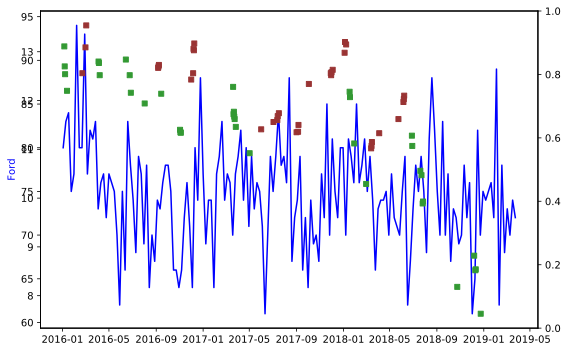

In [570]:
fig, ax1 = plt.subplots()
ax1.plot(ford_key['2016':][keyword], color='b')
ax1.set_ylabel('Ford', color='b')
ax2 = ax1.twinx()
keyword=ford_key.columns[0]
ford['key']=ford_key[keyword];


# ford.index = pd.DatetimeIndex(ford.index)

# ford.reindex(pd.date_range('2014', '2019'), fill_value=0)
ford_key['close']=ford['close']
# print(ford_key)
# print(ford)

# p = ford[ford.columns[~ford.isnull().all()]]
# h = np.correlate(ford["key"], ford["close"])
# print(h)


ax2.plot(buy['2016':]['price'],linestyle='None',markersize = 5.0, marker='s', color='#339933')

ax3 = ax2.twinx()
ax2.plot(sell['2016':]['price'],linestyle='None',markersize = 5.0, marker='s', color='#993333')
# ford_key.pivot_table(keyword, index='Неделя').plot(kind='bar')


fig.tight_layout()
plt.show()